In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import ttest_ind, norm

### Null Hypothesis: Literacy Rate doesn’t affect Crime Rate

### Read Data

In [2]:
crimes_df = pd.read_csv('Dataset/crimes_against_women_2001-2014.csv')

'''
scrap the data wikipedia page
pull only required table with census table
'''

df = pd.read_html('https://en.wikipedia.org/wiki/2011_Census_of_India')
census_df = df[6]

shp_gdf = gpd.read_file('Dataset/Indian_states.shp')

In [3]:
crimes_df.head(2)

,Unnamed: 0,STATE/UT,DISTRICT,Year,Rape,Kidnapping and Abduction,Dowry Deaths,Assault on women with intent to outrage her modesty,Insult to modesty of Women,Cruelty by Husband or his Relatives,Importation of Girls
0,0,ANDHRA PRADESH,ADILABAD,2001,50,30,16,149,34,175,0
1,1,ANDHRA PRADESH,ANANTAPUR,2001,23,30,7,118,24,154,0


In [4]:
census_df.head(2)

,Rank,State / Union Territory (UT),Capital,Type,Population,% of totalpopula-tion[40],Males,Females,SexRatio [41],Literacyrate (%),Rural[42] Population,Urban[42] Population,Area[43] (km2),Density (1/km2),DecadalGrowth%(2001–11)
0,1,Uttar Pradesh,Lucknow,State,199812341,16.50,104480510,95331831,912,67.68,155111022,44470455,240928,828,20.1%
1,2,Maharashtra,Mumbai,State,112374333,9.28,58243056,54131277,929,82.34,61545441,50827531,307713,365,16.0%


In [5]:
shp_gdf.head(2)

,st_nm,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."


## Data Cleaning 

### Check dtypes

In [6]:
print(f'''(crimes_df = \n{crimes_df.dtypes}\n
census_df = \n{census_df.dtypes}\n
shp_gdf = \n{shp_gdf.dtypes})''' )

(crimes_df = 
Unnamed: 0                                              int64
STATE/UT                                               object
DISTRICT                                               object
Year                                                    int64
Rape                                                    int64
Kidnapping and Abduction                                int64
Dowry Deaths                                            int64
Assault on women with intent to outrage her modesty     int64
Insult to modesty of Women                              int64
Cruelty by Husband or his Relatives                     int64
Importation of Girls                                    int64
dtype: object

census_df = 
Rank                             object
State / Union Territory (UT)     object
Capital                          object
Type                             object
Population                        int64
% of totalpopula-tion[40]       float64
Males                             in

##### Crimes_df

Remove unwanted columns

In [7]:
crimes_df.drop('Unnamed: 0', axis=1, inplace=True)

##### Census_df

Correct `census_df = Rank object` to int64

In [8]:
census_df.tail(4)

,Rank,State / Union Territory (UT),Capital,Type,Population,% of totalpopula-tion[40],Males,Females,SexRatio [41],Literacyrate (%),Rural[42] Population,Urban[42] Population,Area[43] (km2),Density (1/km2),DecadalGrowth%(2001–11)
32,33,Dadra and Nagar Haveli,Silvassa,UT,343709,0.03,193760,149949,774,76.24,183024,159829,491,698,55.5%
33,34,Daman and Diu,Daman,UT,243247,0.02,150301,92946,618,87.10,60331,182580,112,2169,53.5%
34,35,Lakshadweep,Kavaratti,UT,64473,0.01,33123,31350,946,91.85,14121,50308,32,2013,6.2%
35,India,India,NaN,35,1210854977,100.00,623724248,586469174,943,74.04,833087662,377105760,3287240,382,17.64%


In [9]:
# Remove the last row - unwanted data
census_df=census_df[:-1]

# chnage the dtype
census_df=census_df.astype({'Rank': 'int32'})
census_df.dtypes

Rank                              int32
State / Union Territory (UT)     object
Capital                          object
Type                             object
Population                        int64
% of totalpopula-tion[40]       float64
Males                             int64
Females                           int64
SexRatio [41]                     int64
Literacyrate (%)                float64
Rural[42] Population              int64
Urban[42] Population              int64
Area[43] (km2)                    int64
Density (1/km2)                   int64
DecadalGrowth%(2001–11)          object
dtype: object

##### shp_gdf

No dtype changes is required

### Renaming the columns

In [10]:
# renaming the columns for better understanding 

crimes_df.columns = ["state/ut", "district","year","rape","kidnapping","dowry_deaths","assault","insult_to_modesty",
                 "cruelty_by_husband","trafficking"]

In [11]:
census_df.rename(columns = {'State / Union Territory (UT)':'state/ut'}, inplace=True)

### Check null values

In [12]:
crimes_df.isnull().sum()

state/ut              0
district              0
year                  0
rape                  0
kidnapping            0
dowry_deaths          0
assault               0
insult_to_modesty     0
cruelty_by_husband    0
trafficking           0
dtype: int64

In [13]:
census_df.isnull().sum()

Rank                         0
state/ut                     0
Capital                      0
Type                         0
Population                   0
% of totalpopula-tion[40]    0
Males                        0
Females                      0
SexRatio [41]                0
Literacyrate (%)             0
Rural[42] Population         0
Urban[42] Population         0
Area[43] (km2)               0
Density (1/km2)              0
DecadalGrowth%(2001–11)      0
dtype: int64

In [14]:
shp_gdf.isnull().sum()

st_nm       0
geometry    0
dtype: int64

### Check data column `state/ut` for merge ready

   * State and UT nmaes are differently and misplaced in our dataframes. Let's replace them with similar names so our data will be merge ready on `state/ut` column
   * Renaming of columns for merge ease

#### Crimes_df

In [15]:
# check unique values
print(f"Before_crimes_df_state_unique_values = \n\n{crimes_df['state/ut'].unique()}\n\n")

# Naming correction

crimes_df['state/ut']=crimes_df['state/ut'].str.lower().str.replace(' ','')
crimes_df['district'] = crimes_df['district'].str.lower().str.replace(' ','')

# check unique states

print(f"After_crimes_df_state_unique_values = \n\n{crimes_df['state/ut'].unique()}")

Before_crimes_df_state_unique_values = 

['ANDHRA PRADESH' 'ARUNACHAL PRADESH' 'ASSAM' 'BIHAR' 'CHHATTISGARH' 'GOA'
 'GUJARAT' 'HARYANA' 'HIMACHAL PRADESH' 'JAMMU & KASHMIR' 'JHARKHAND'
 'KARNATAKA' 'KERALA' 'MADHYA PRADESH' 'MAHARASHTRA' 'MANIPUR' 'MEGHALAYA'
 'MIZORAM' 'NAGALAND' 'ODISHA' 'PUNJAB' 'RAJASTHAN' 'SIKKIM' 'TAMIL NADU'
 'TRIPURA' 'UTTAR PRADESH' 'UTTARAKHAND' 'WEST BENGAL' 'A & N ISLANDS'
 'CHANDIGARH' 'D & N HAVELI' 'DAMAN & DIU' 'DELHI' 'LAKSHADWEEP'
 'PUDUCHERRY' 'Andhra Pradesh' 'Arunachal Pradesh' 'Assam' 'Bihar'
 'Chhattisgarh' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh'
 'Jammu & Kashmir' 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh'
 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha'
 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal' 'A&N Islands' 'Chandigarh' 'D&N Haveli'
 'Daman & Diu' 'Delhi UT' 'Lakshadweep' 'Puducherry' 'Telangana'
 'A & N Islands']


After_crimes_df_state_unique_values = 

[

#### Census_df

In [16]:
# check unique values

print(f"Before_census_df_state_unique_values = \n\n{census_df['state/ut'].unique()}\n\n")

# replace values to match crime_df data

replace_values = {'andhrapradesh[a]': 'andhrapradesh', 'andamanandnicobarislands': 'a&nislands', 
            'dadraandnagarhaveli': 'd&nhaveli', 'jammuandkashmir': 'jammu&kashmir', 'damananddiu' : 'daman&diu'
}

census_df['state/ut']=census_df['state/ut'].str.lower().str.replace(' ','')

census_df = census_df.replace({"state/ut": replace_values}) 


print(f"After_census_df_state_unique_values = \n\n{census_df['state/ut'].unique()}")

Before_census_df_state_unique_values = 

['Uttar Pradesh' 'Maharashtra' 'Bihar' 'West Bengal' 'Andhra Pradesh[a]'
 'Madhya Pradesh' 'Tamil Nadu' 'Rajasthan' 'Karnataka' 'Gujarat' 'Odisha'
 'Kerala' 'Jharkhand' 'Assam' 'Punjab' 'Chhattisgarh' 'Haryana' 'Delhi'
 'Jammu and Kashmir' 'Uttarakhand' 'Himachal Pradesh' 'Tripura'
 'Meghalaya' 'Manipur' 'Nagaland' 'Goa' 'Arunachal Pradesh' 'Puducherry'
 'Mizoram' 'Chandigarh' 'Sikkim' 'Andaman and Nicobar Islands'
 'Dadra and Nagar Haveli' 'Daman and Diu' 'Lakshadweep']


After_census_df_state_unique_values = 

['uttarpradesh' 'maharashtra' 'bihar' 'westbengal' 'andhrapradesh'
 'madhyapradesh' 'tamilnadu' 'rajasthan' 'karnataka' 'gujarat' 'odisha'
 'kerala' 'jharkhand' 'assam' 'punjab' 'chhattisgarh' 'haryana' 'delhi'
 'jammu&kashmir' 'uttarakhand' 'himachalpradesh' 'tripura' 'meghalaya'
 'manipur' 'nagaland' 'goa' 'arunachalpradesh' 'puducherry' 'mizoram'
 'chandigarh' 'sikkim' 'a&nislands' 'd&nhaveli' 'daman&diu' 'lakshadweep']


#### Shp_gdf

In [17]:
print(f"Before_clean_shp_state_unique_values = \n\n{shp_gdf['st_nm'].unique()}\n\n")

# replace values to match crime_df data

shp_gdf.st_nm=shp_gdf.st_nm.str.lower().str.replace(' ','')
replace_values_st = {'andaman&nicobarisland': 'a&nislands', 'dadara&nagarhavelli': 'd&nhaveli',
 'nctofdelhi': 'delhi', 'orissa': 'odisha', 'arunanchalpradesh': 'arunachalpradesh'
}
shp_gdf = shp_gdf.replace({"st_nm": replace_values_st}) 

print(f"After_clean_shp_state_unique_values = \n\n{shp_gdf['st_nm'].unique()}\n\n")

Before_clean_shp_state_unique_values = 

['Andaman & Nicobar Island' 'Arunanchal Pradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'Dadara & Nagar Havelli' 'Daman & Diu' 'Goa'
 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu & Kashmir' 'Jharkhand'
 'Karnataka' 'Kerala' 'Lakshadweep' 'Madhya Pradesh' 'Maharashtra'
 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'NCT of Delhi' 'Puducherry'
 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana' 'Tripura'
 'Uttar Pradesh' 'Uttarakhand' 'West Bengal' 'Odisha' 'Andhra Pradesh']


After_clean_shp_state_unique_values = 

['a&nislands' 'arunachalpradesh' 'assam' 'bihar' 'chandigarh'
 'chhattisgarh' 'd&nhaveli' 'daman&diu' 'goa' 'gujarat' 'haryana'
 'himachalpradesh' 'jammu&kashmir' 'jharkhand' 'karnataka' 'kerala'
 'lakshadweep' 'madhyapradesh' 'maharashtra' 'manipur' 'meghalaya'
 'mizoram' 'nagaland' 'delhi' 'puducherry' 'punjab' 'rajasthan' 'sikkim'
 'tamilnadu' 'telangana' 'tripura' 'uttarpradesh' 'uttarakhand'
 'westbengal' 'odisha' 'andhrap

## Reports:

### Sanity Checks:

* dtype checks looks good
* No null values are present, hence no imputing methods are used.

### Data Cleaning:

* Renamed few columns for better understanding.
* Removed unwanted columns
* unique values on 'state\ut' column had data duplicates which is cleaned.
* All 3 dataframes 'state\ut' column should have similar namings as this column will be used for merge, which is cleaned as well.

Now Data is ready for Merege!!

### Merge Datasets

In [18]:
# crime data pull only year 2011 because census happens every 10th year in India.

columns = ["rape","kidnapping","dowry_deaths","assault","insult_to_modesty",
           "cruelty_by_husband","trafficking"]
crimes_df_2011 = crimes_df[crimes_df['year']==2011]

# create total_crime column 

sum_cols = ["rape","kidnapping","dowry_deaths","assault","insult_to_modesty",
        "cruelty_by_husband","trafficking"]
crimes_df_2011['total_crimes'] = crimes_df_2011[sum_cols].sum(axis=1)

# Now we have crime data of 2011 and census 2011 information which can be merged
# Merge
merged_df = pd.merge(crimes_df_2011, census_df, on="state/ut", how='inner')

print(f'merged_df shape = {merged_df.shape}')
merged_df.head(3) 

merged_df shape = (791, 25)


/var/folders/wb/mynt_v_579n87q8ddq2_5w300000gn/T/ipykernel_12104/1072401482.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_df_2011['total_crimes'] = crimes_df_2011[sum_cols].sum(axis=1)


,state/ut,district,year,rape,kidnapping,dowry_deaths,assault,insult_to_modesty,cruelty_by_husband,trafficking,...,% of totalpopula-tion[40],Males,Females,SexRatio [41],Literacyrate (%),Rural[42] Population,Urban[42] Population,Area[43] (km2),Density (1/km2),DecadalGrowth%(2001–11)
0,andhrapradesh,adilabad,2011,84,70,20,112,142,429,0,...,6.99,42442146,42138631,993,67.02,56361702,28219075,275045,308,10.98%
1,andhrapradesh,anantapur,2011,16,83,36,156,16,198,0,...,6.99,42442146,42138631,993,67.02,56361702,28219075,275045,308,10.98%
2,andhrapradesh,chittoor,2011,17,47,25,124,168,421,0,...,6.99,42442146,42138631,993,67.02,56361702,28219075,275045,308,10.98%


### EDA

In [19]:
# Crime analysis 

class crime_analysis:
    
    def __init__(self, df, crime_columns, shp_gdf):
        self.df = df
        self.crime_columns = crime_columns
        self.shp_gdf = shp_gdf
        
    # States with max crimes
    def plot_st_max_crime(self, df, shp_gdf):
        
        # Pull state data
        self.merged_st_data = df.groupby('state/ut')['total_crimes'].sum()

        self.merged_new = shp_gdf.set_index('st_nm').join(self.merged_st_data)

        # Geoplot
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.axis('off')
        ax.set_title('Total crimes on women in India as of 2011',
                     fontdict={'fontsize': '15', 'fontweight' : '3'})

        fig = self.merged_new.plot(column='total_crimes', cmap='Reds', linewidth=0.5, 
                                   ax=ax, edgecolor='0.2',legend=True, legend_kwds={'label': "Number of crimes"})
        
        # Top 10 states histplot
        self.merged_crime = df.sort_values(by = 'total_crimes', ascending=False).head(10)
        
        # adding color palette
        pal = sns.color_palette("Reds_d", 10)
        plt.figure(figsize=(14, 5))
        sns.barplot(data=self.merged_crime, x=self.merged_crime['state/ut'], y='total_crimes', 
                    palette=np.array(pal[::-1]))
        
        plt.show()
    
    # Create dataframe for each crime category 
    def create_crime_df(self, df, crime_columns):
        
        self.df_arr = []
        for crime_col in crime_columns:
            self.df_arr.append(pd.DataFrame(df.groupby(['state/ut','year'])[crime_col].sum().reset_index()))
        return self.df_arr
    
    # Pull Top 5 states contents for each crime category
    def create_top_5_crime_df(self, df, crime_columns):
        
        # call create_crime_df function
        self.df_a = self.create_crime_df(df, crime_columns)
        
        self.df_tp_5_a = []
        for df in self.df_a:
            self.df_tp_5_a.append(df[(df['state/ut']=="uttarpradesh") |\
                              (df['state/ut']=='westbengal') |\
                              (df['state/ut']=='andhrapradesh') |\
                              (df['state/ut']=='madhyapradesh') |\
                              (df['state/ut']=='rajasthan')])
        return self.df_tp_5_a
    
    # Plot each crime category graph for Top 5 states
    def plot_crime_top_5_st_graph(self, df, crime_columns):
        
        # call create top 5 crime df function
        self.df_tp_5_arr = self.create_top_5_crime_df(df, crime_columns)
        
        fig1, ax1 = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False, figsize=(19,7))
        
        ax1 = ax1.ravel()
        
        for i in range(len(self.df_tp_5_arr)):
            
            ax1[i].scatter(self.df_tp_5_a[i]['state/ut'], self.df_tp_5_a[i].iloc[:,-1:])
            ax1[i].set(ylabel=f'{self.df_tp_5_a[i].columns[2]} cases')
            ax1[i].set_title(f'Number of {self.df_tp_5_a[i].columns[2]} crime cases')
            

In [20]:
# Creating class pointer for further analysis:
crime_columns = ['rape', 'kidnapping', 'dowry_deaths', 
                  'cruelty_by_husband', 'assault', 'trafficking']

# Crime analysis Class pointer
ca = crime_analysis(merged_df, crime_columns, shp_gdf)

### 1. State's with max crime rates

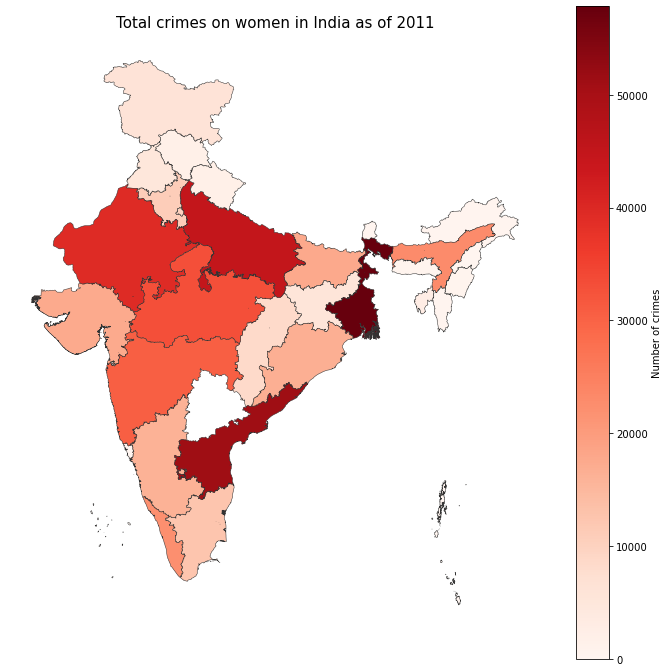

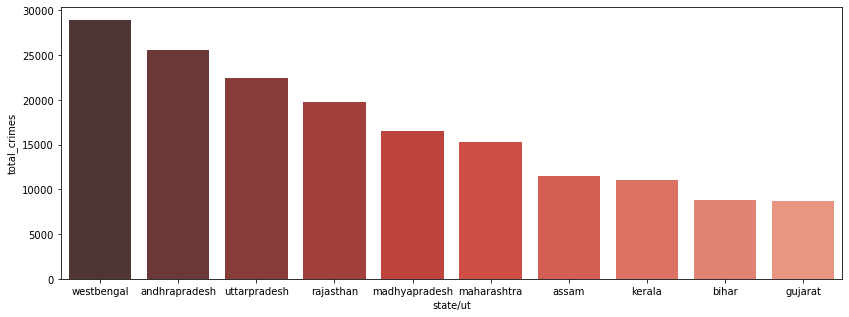

In [21]:
# State's with max crime rates

ca.plot_st_max_crime(merged_df, shp_gdf)

#### Analysis:

West Bengal has the highest number of crime rates. Followed by Andra Pradesh, Uttar Pradesh, Rajasthan, Madhya Pradesh and Assam.

Least crime rate states are Lakshadweep, daman and diu, daman and haveli.

### 2. Top 5 states crime rate for each crime category

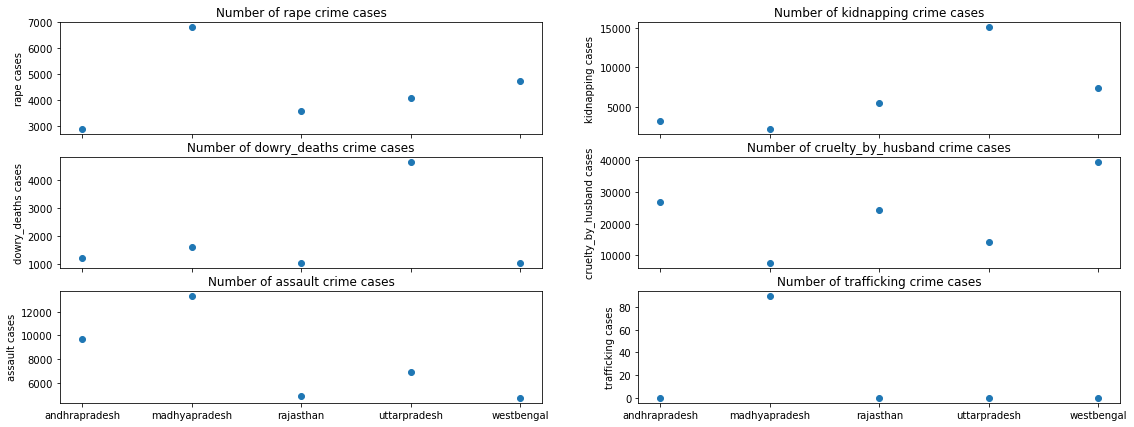

In [22]:
ca.plot_crime_top_5_st_graph(merged_df, crime_columns)

#### Analysis

* Westbengal has max total crime cases out of which max crime categories are - Cruelty_by_husband followed by Kidnaapping and Rape Cases.

* Madhya Pradesh has highest number of assault, rape, and  trafficking crime cases compared to other states.

In [23]:
# Literacy population anlaysis class

class lit_pop_analysis:
    def __init__(self, df, census_df, shp_gdf):
        self.df = df
        self.census_df = census_df
        self.shp_gdf = shp_gdf
        
    # States with max Literacy rates
    def plot_max_st_lit_rate(self, census_df, shp_gdf):
        
        # get only required columns
        self.census_df_lit = census_df.set_index('state/ut')

        self.merged_lit = shp_gdf.set_index('st_nm').join(self.census_df_lit['Literacyrate (%)'])

        # plot

        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.axis('off')
        ax.set_title('Literacy Rate in India as of 2011',
                     fontdict={'fontsize': '15', 'fontweight' : '3'})

        fig = self.merged_lit.plot(column='Literacyrate (%)', cmap='Greens', linewidth=0.5, ax=ax, 
                                   edgecolor='0.2',legend=True, legend_kwds={'label': "Literacyrate (%)"})
        
        # Top 8 states
        
        self.merged_litr = self.merged_lit.sort_values(by = 'Literacyrate (%)', ascending=False).head(8)
        
        pal = sns.color_palette("Greens_d", 8)
        plt.figure(figsize=(15, 5))
        sns.histplot(data=self.merged_litr, x=self.merged_litr.index, y='Literacyrate (%)', 
                     color='green')
        
        # Bottom 8 states
        
        self.merged_litr = self.merged_lit.sort_values(by = 'Literacyrate (%)', ascending=True).head(8)
        
        pal = sns.color_palette("coolwarm_d", 8)
        plt.figure(figsize=(15, 5))
        sns.histplot(data=self.merged_litr, x=self.merged_litr.index, y='Literacyrate (%)', 
                     color='black')
        
     
    # Least Populated
    def plot_pop_least_graph(self, census_df):
        plt.figure(figsize=(20,5))
        sns.barplot(data=census_df.sort_values('% of totalpopula-tion[40]').head(15), x='state/ut', 
                    y='% of totalpopula-tion[40]')
        
    # Highest Populted
    def plot_pop_max_graph(self, census_df):
        plt.figure(figsize=(20,5))
        sns.barplot(data=census_df.head(15), x='state/ut', y='% of totalpopula-tion[40]')
        
    # Literacy v/s crime rate
    def plot_lit_crime_graph(self, df):
        self.state_df = df.groupby('state/ut')
        self.crime_lit_df = pd.DataFrame()
        
        # Calculate total population
        self.crime_lit_df['Urabn Population'] = pd.DataFrame(self.state_df['Urban[42] Population'].mean())
        self.crime_lit_df['Rural Population'] = pd.DataFrame(self.state_df['Rural[42] Population'].mean())
        self.crime_lit_df['Population'] = self.crime_lit_df['Urabn Population']+self.crime_lit_df['Rural Population']

        # Pull total_crimes, lit_rate, crime_rate
        self.crime_lit_df['total_crimes']=pd.DataFrame(self.state_df['total_crimes'].sum())
        self.crime_lit_df['Literacyrate (%)']=pd.DataFrame(self.state_df['Literacyrate (%)'].mean())
        
        # Calculate crime rate
        self.crime_lit_df['crime_rate']=round((self.crime_lit_df['total_crimes']/\
                                               self.crime_lit_df['Population']*10000),2)

        self.crime_lit_df = self.crime_lit_df.reset_index()
        self.crime_lit_df = self.crime_lit_df.sort_values(['total_crimes', 'Literacyrate (%)'])
        
        plt.figure(figsize=(20,5))
        sns.barplot(data=self.crime_lit_df, x='Literacyrate (%)', y='total_crimes')
        
        self.cols = ['state/ut', 'Population', 'total_crimes', 'crime_rate', 'Literacyrate (%)']
        print(self.crime_lit_df[self.cols])
        
        return self.crime_lit_df

In [24]:
# Literacy analysis Class pointer

la = lit_pop_analysis(merged_df, census_df, shp_gdf)

### 3. State's Literacy Rate 

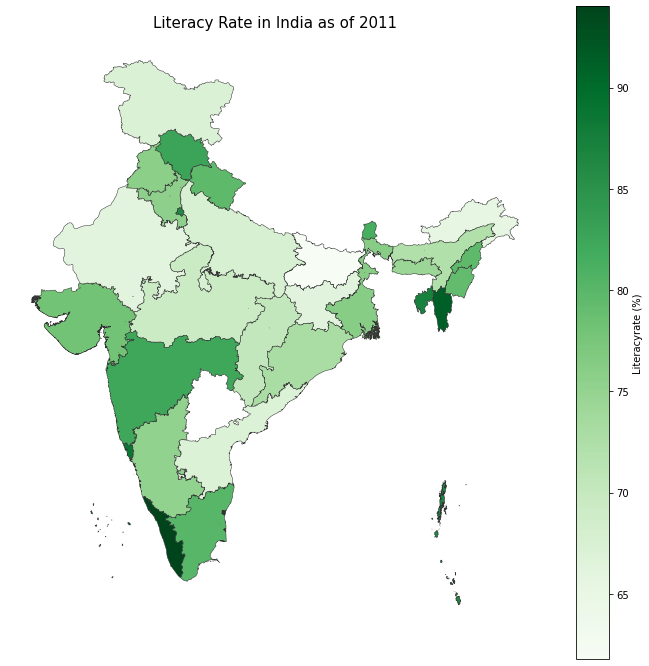

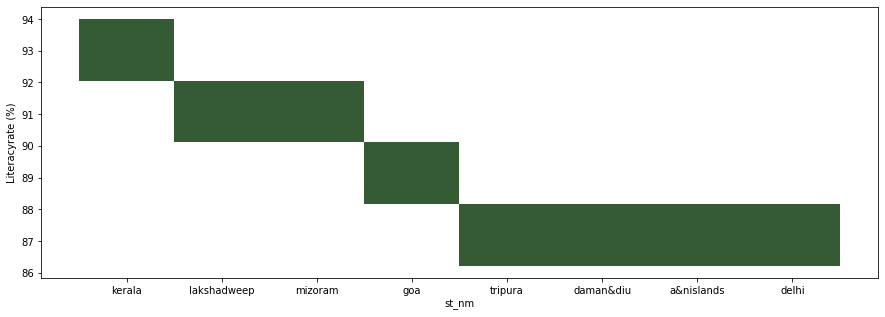

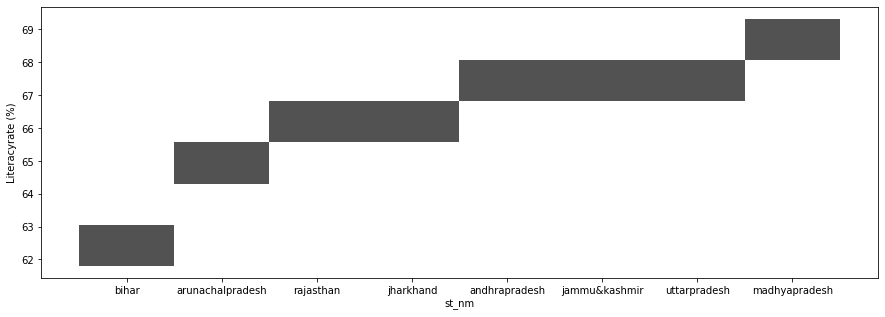

In [25]:
la.plot_max_st_lit_rate(census_df, shp_gdf)

#### Analysis

Max litreacy rate found in Kerala, lakshadweep, Mizoram, and goa.Whereas avg literacy rate found in Bihar, Arunachal Pradesh, Rajasthan, Jharkhand, AP, Jammu & Kashmir and UP.

### 4. State's Population distribution

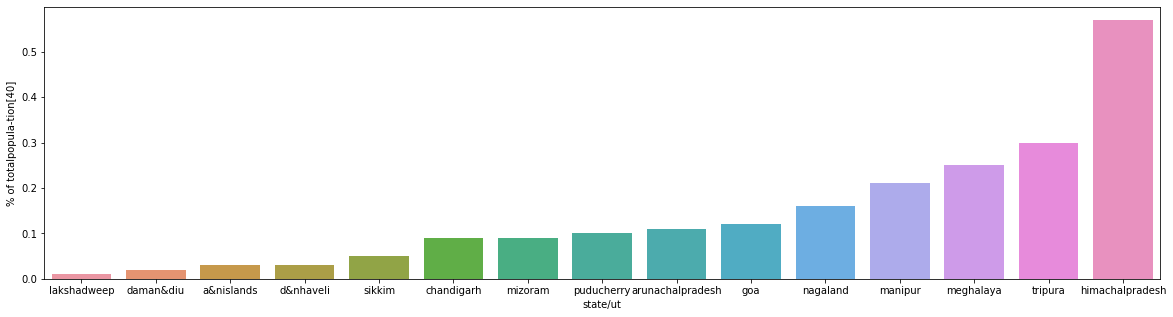

In [26]:
# Plot least populated areas

la.plot_pop_least_graph(census_df)

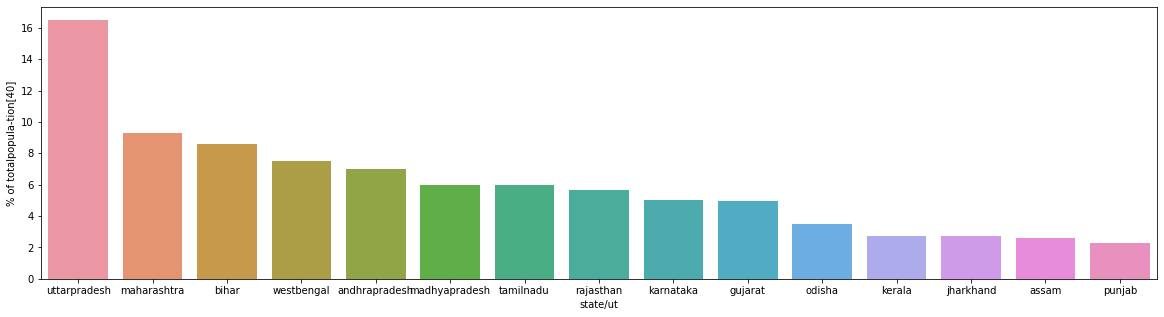

In [27]:
# Highest Populted

la.plot_pop_max_graph(census_df)

#### Analysis

Max populated states are UP, Maharastra, bihar and MP. Whereas least populated states are lakshadweep, d&nhaveli

### 5. Literacy vs Crime Rate

            state/ut   Population  total_crimes  crime_rate  Literacyrate (%)
18       lakshadweep      64429.0             0        0.00             91.85
8          daman&diu     242911.0            10        0.41             87.10
7          d&nhaveli     342853.0            34        0.99             76.24
24          nagaland    1980602.0            72        0.36             79.55
0         a&nislands     379944.0            96        2.53             86.63
29            sikkim     607688.0           108        1.78             81.42
26        puducherry    1244464.0           156        1.25             85.85
10               goa    1457723.0           212        1.45             88.70
5         chandigarh    1054686.0           308        2.92             86.05
23           mizoram    1091034.0           318        2.91             91.33
2   arunachalpradesh    1382611.0           342        2.47             65.38
21           manipur    2721756.0           494        1.82     

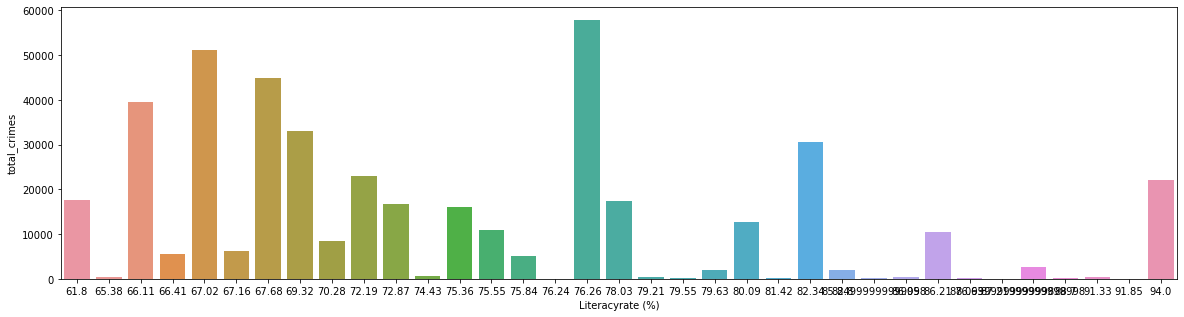

In [28]:
# Literacy v/s crime rate
crime_lit_df=la.plot_lit_crime_graph(merged_df)

#### Analysis

The graph clearly shows that, when literate rate is greater than 75% the number of total_crimes kept decreasing.<br> 
<br>
Meaning, as more and more literate population will have less crime cases shall be seen.

### T-Test


* Null Hypothesis: litercay rate doesn’t affect crime rate 
* Alternate Hypothesis: litercay rate does affect crime rate 

In [29]:
'''
Threshold calculations:

I am considering total_crimes > 10,000 as "High crime rate" and < 10,000 as "Low crime rate" in the dataset.
      
Similarly, Literacyrate (%) > 70% as "Highly Educated" and less than 70% as "Less Educated".
'''


crime_lit_df['total_crimes_cal'] = crime_lit_df['total_crimes'].apply(lambda x : 0 if x < 10000 else 1)
crime_lit_df['Literacyrate (%)_cal'] = crime_lit_df['Literacyrate (%)']\
                                         .apply(lambda x : 0 if x < 70 else 1)

In [30]:
# Apply t-test with threshold set

t_stat, p_val = ttest_ind(crime_lit_df['total_crimes_cal'], crime_lit_df['Literacyrate (%)_cal'])

if (p_val<0.05):
    Hypothesis_Status = 'Reject Null Hypothesis : Significant'
else:
    Hypothesis_Status = 'Do not reject Null Hypothesis : Not Significant'

print (p_val)
print (Hypothesis_Status)

0.002983036815808353
Reject Null Hypothesis : Significant


## Summary

### Patterns observed

#### Sec 1:

##### Analysis:

West Bengal has the highest number of crime rates. Followed by Andra Pradesh, Uttar Pradesh, Rajasthan, Madhya Pradesh and Assam.

Least crime rate states are Lakshadweep, daman and diu, daman and haveli.


#### Sec 2:

##### Analysis:

Westbengal has max total crime cases out of which max crime categories are - Cruelty_by_husband followed by Kidnaapping and Rape Cases.

Madhya Pradesh has highest number of assault, rape, and  trafficking crime cases compared to other states.

#### Sec 3:

##### Analysis:

Max litreacy rate found in Kerala, lakshadweep, Mizoram, and goa.Whereas avg literacy rate found in Bihar, Arunachal Pradesh, Rajasthan, Jharkhand, AP, Jammu & Kashmir and UP.

#### Sec 4:

##### Analysis:

Max populated states are UP, Maharastra, bihar and MP. Whereas least populated states are lakshadweep, d&nhaveli.

#### Sec 5:

##### Analysis:

The graph clearly shows that, when literate rate is greater than 75% the number of total_crimes kept decreasing.<br> 
<br>
Meaning, as more and more literate population will have less crime cases shall be seen.

#### Sec 6:

##### T-Test Analysis:

Reject Null Hypothesis : Significant

## Conclusion:

##### The above provided anlaysis clearly shows that we should void the Null Hypothesis, which means `Litreacy Rate does affect the Crime Rate`.